In [21]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import numpy as np

sns.set(style="whitegrid")

In [2]:
# Upload File
from google.colab import files
uploaded = files.upload()

Saving istanbul_metro_monthly_all_lines_with_tram_funicular.csv to istanbul_metro_monthly_all_lines_with_tram_funicular.csv


In [ ]:
# Load Data
df = pd.read_csv("istanbul_metro_monthly_all_lines_with_tram_funicular.csv")
df.head()

,Year,Month,Metro Line,Passengers
0,2019,April,M1,12739273
1,2019,August,M1,10951303
2,2019,December,M1,13077123
3,2019,February,M1,11858209
4,2019,January,M1,12672664


In [ ]:
 # Clean and Prepare
df['Month'] = pd.Categorical(df['Month'], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)
df = df.sort_values(by=["Year", "Month"])

<ipython-input-30-84e981fa9c93>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_totals = df.groupby(["Year", "Month"])["Passengers"].sum().reset_index()


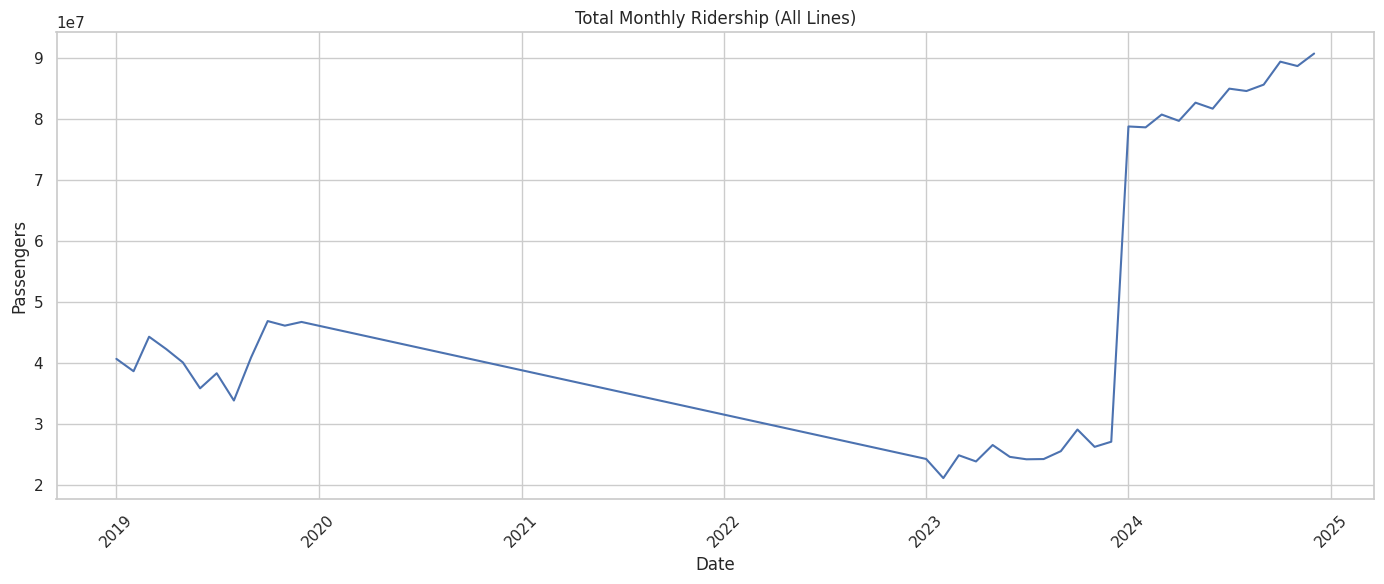

In [ ]:
# Total Monthly Ridership Over Time
plt.figure(figsize=(14, 6))
monthly_totals = df.groupby(["Year", "Month"])["Passengers"].sum().reset_index()
monthly_totals["Date"] = monthly_totals["Year"].astype(str) + "-" + monthly_totals["Month"].astype(str)
monthly_totals["Date"] = pd.to_datetime(monthly_totals["Date"], format="%Y-%B")
sns.lineplot(data=monthly_totals, x="Date", y="Passengers")
plt.title("Total Monthly Ridership (All Lines)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-31-230491e505c8>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df[df["Year"] == 2024], x="Metro Line", y="Passengers", estimator=sum, ci=None)


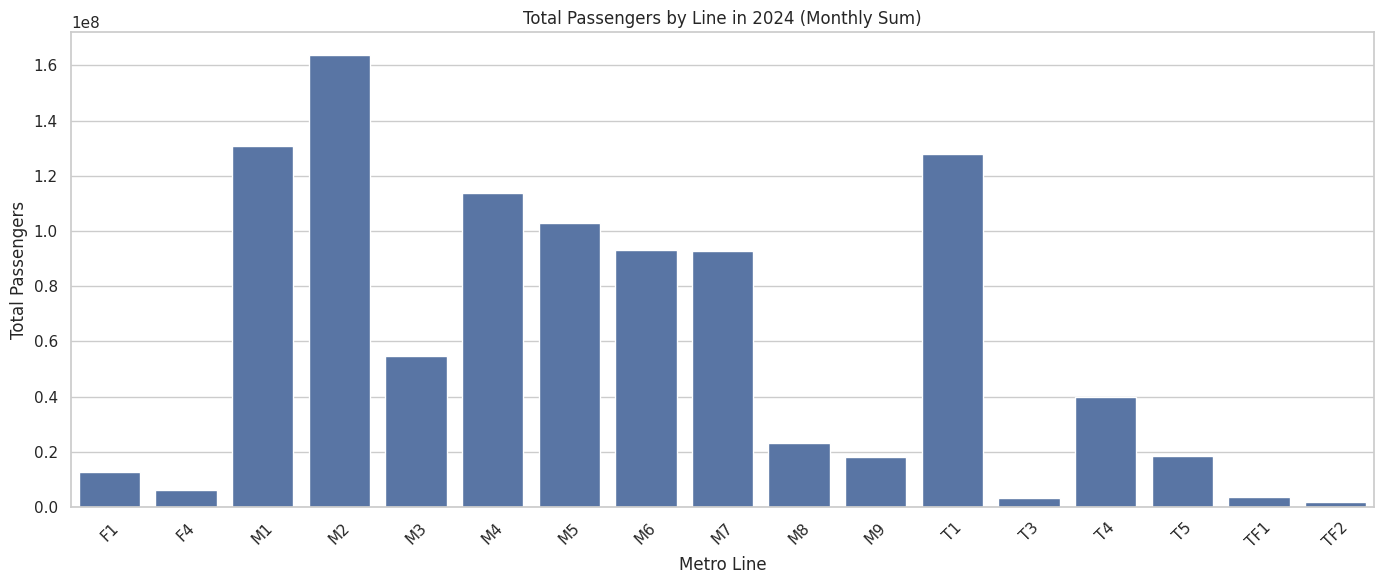

In [ ]:
# Monthly Breakdown by Line (2024 Example)
plt.figure(figsize=(14, 6))
sns.barplot(data=df[df["Year"] == 2024], x="Metro Line", y="Passengers", estimator=sum, ci=None)
plt.title("Total Passengers by Line in 2024 (Monthly Sum)")
plt.ylabel("Total Passengers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

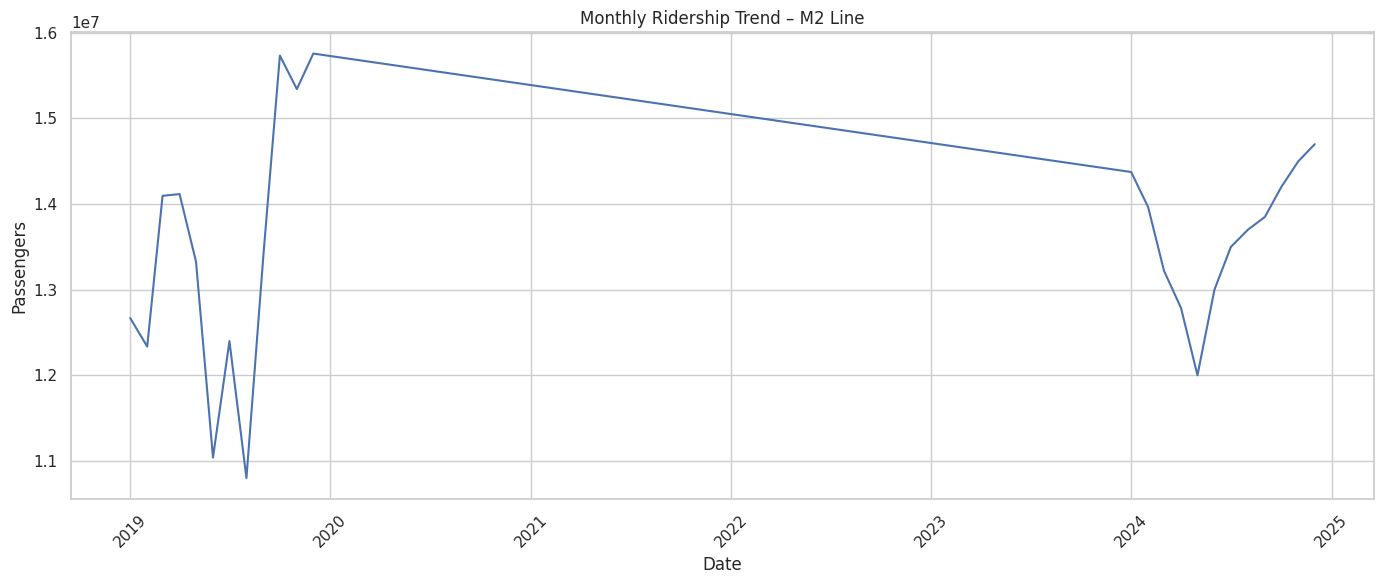

In [ ]:
# Line-specific Trend: Example for M2
plt.figure(figsize=(14, 6))
m2_data = df[df["Metro Line"] == "M2"].copy()
m2_data["Date"] = m2_data["Year"].astype(str) + "-" + m2_data["Month"].astype(str)
m2_data["Date"] = pd.to_datetime(m2_data["Date"], format="%Y-%B")
sns.lineplot(data=m2_data, x="Date", y="Passengers")
plt.title("Monthly Ridership Trend – M2 Line")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Hypothesis Test
#General Function for Monthly T-Test
def compare_monthly_ridership(line, year1, year2):

  data1 = df[(df["Metro Line"] == line) & (df["Year"] == year1)]["Passengers"]
  data2 = df[(df["Metro Line"] == line) & (df["Year"] == year2)]["Passengers"]

  if len(data1) < 2 or len(data2) < 2:
      print(f"🚫 Not enough data for t-test on line {line} between {year1} and {year2}")
      return

  t_stat, p_val = ttest_ind(data1, data2)

  print(f"📊 Monthly T-Test for {line}: {year2} vs {year1}")
  print(f"T-statistic: {t_stat:.4f}")
  print(f"P-value: {p_val:.4f}")

  if p_val < 0.05:
      print("🚨 Significant difference in average monthly ridership.")
  else:
      print("✅ No statistically significant difference.")

# Example usage:
compare_monthly_ridership("M2", 2019, 2024)


📊 Monthly T-Test for M2: 2024 vs 2019
T-statistic: -0.4325
P-value: 0.6696
✅ No statistically significant difference.


### Hypothesis Test: M2 Monthly Ridership (2019 vs 2024)

**Null Hypothesis (H₀):**There is no difference in average monthly ridership of M2 between 2019 and 2024.  
**Alternative Hypothesis (H₁):** There is a significant difference in average monthly ridership of M2 between 2019 and 2024.

Using a two-sample t-test on monthly data, we obtained a **p-value of 0.6696**.  
Since this value is greater than the significance level of 0.05, we **fail to reject the null hypothesis**.  
This means there is **no statistically significant change** in average monthly ridership on the M2 line between 2019 and 2024.

In [ ]:
compare_monthly_ridership("M7", 2023, 2024)

📊 Monthly T-Test for M7: 2024 vs 2023
T-statistic: -4.4747
P-value: 0.0002
🚨 Significant difference in average monthly ridership.


In [ ]:
compare_monthly_ridership("T5", 2023, 2024)

📊 Monthly T-Test for T5: 2024 vs 2023
T-statistic: -7.0221
P-value: 0.0000
🚨 Significant difference in average monthly ridership.


## Phase 3: Machine Learning

## ML Method 1: Linear Regression model
We used a Linear Regression model to predict monthly passenger ridership for individual metro lines.

In [5]:
# Upload File
from google.colab import files
uploaded = files.upload()

Saving istanbul_metro_enriched_with_population.csv to istanbul_metro_enriched_with_population (1).csv


In [6]:
# Load the enriched dataset
df = pd.read_csv("istanbul_metro_enriched_with_population.csv")

In [15]:
def predict_passengers_with_forecast(line_name, forecast_year=2025):
    df_line = df[df["Metro Line"] == line_name].copy()

    # Encode month
    month_encoder = LabelEncoder()
    df_line["MonthEncoded"] = month_encoder.fit_transform(df_line["Month"])

    # Train model
    X = df_line[["Year", "MonthEncoded", "Population"]]
    y = df_line["Passengers"]
    model = LinearRegression()
    model.fit(X, y)

    # Predict existing data
    df_line["Predicted"] = model.predict(X)

    # Forecast for given year
    months = df_line["Month"].unique()
    months_encoded = month_encoder.transform(months)
    population_2025 = 16600000
    forecast_X = pd.DataFrame({
        "Year": [forecast_year] * len(months),
        "MonthEncoded": months_encoded,
        "Population": [population_2025] * len(months),
    })

    forecast_preds = model.predict(forecast_X)
    df_forecast = pd.DataFrame({
        "Year": [forecast_year] * len(months),
        "Month": months,
        "Predicted Passengers": forecast_preds.astype(int)
    })

    # Construct time axis values
    df_line["Date"] = df_line["Year"].astype(str) + "-" + df_line["Month"]
    df_forecast["Date"] = df_forecast["Year"].astype(str) + "-" + df_forecast["Month"]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_line["Date"], y, label="Actual", marker="o")
    plt.plot(df_line["Date"], df_line["Predicted"], label="Predicted", marker="x")
    plt.plot(df_forecast["Date"], df_forecast["Predicted Passengers"], label=f"Forecast {forecast_year}", marker="*", linestyle="--")
    plt.xticks(rotation=60, ha='right')
    plt.title(f"Passenger Forecast for {line_name} (incl. {forecast_year})")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_forecast

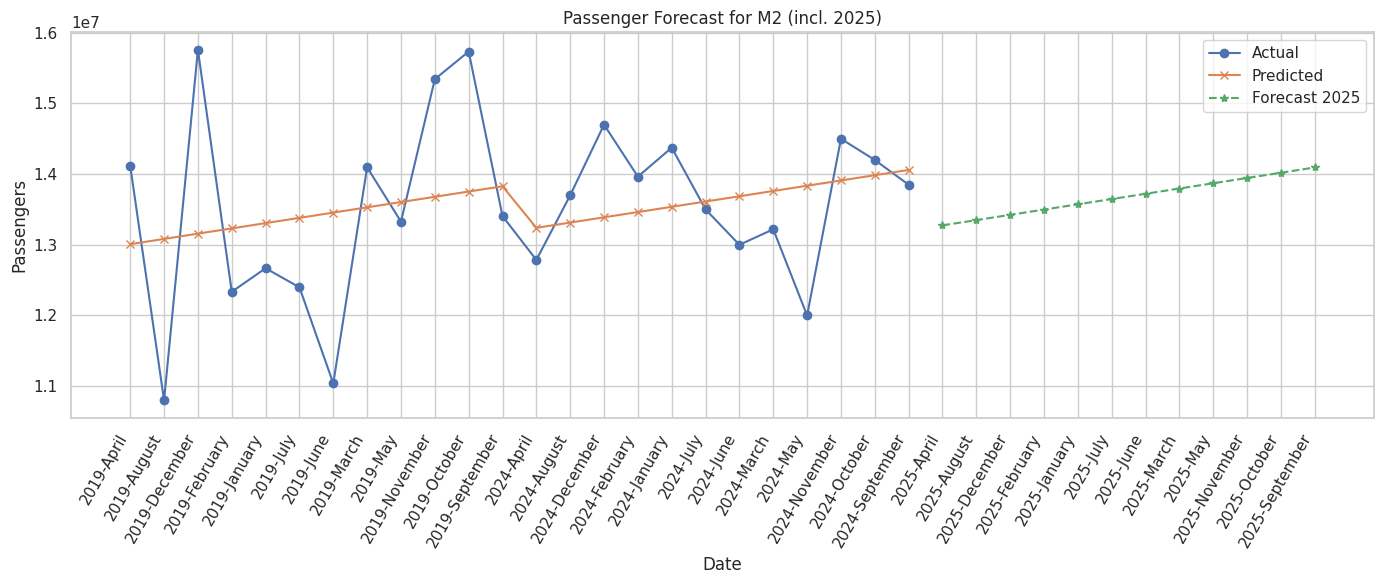

,Year,Month,Predicted Passengers,Date
0,2025,April,13274999,2025-April
1,2025,August,13349482,2025-August
2,2025,December,13423965,2025-December
3,2025,February,13498447,2025-February
4,2025,January,13572930,2025-January
5,2025,July,13647413,2025-July
6,2025,June,13721895,2025-June
7,2025,March,13796378,2025-March
8,2025,May,13870861,2025-May
9,2025,November,13945343,2025-November


In [16]:
# Example: Run the model for M2
predict_passengers_with_forecast("M2")

## Can It Forecast Beyond 2025?
  “Due to the simplicity of the Linear Regression model and the slow changes in
  population and year-based input features, the model produces smooth, linear
  growth in predictions for 2026–2028, and so on.”


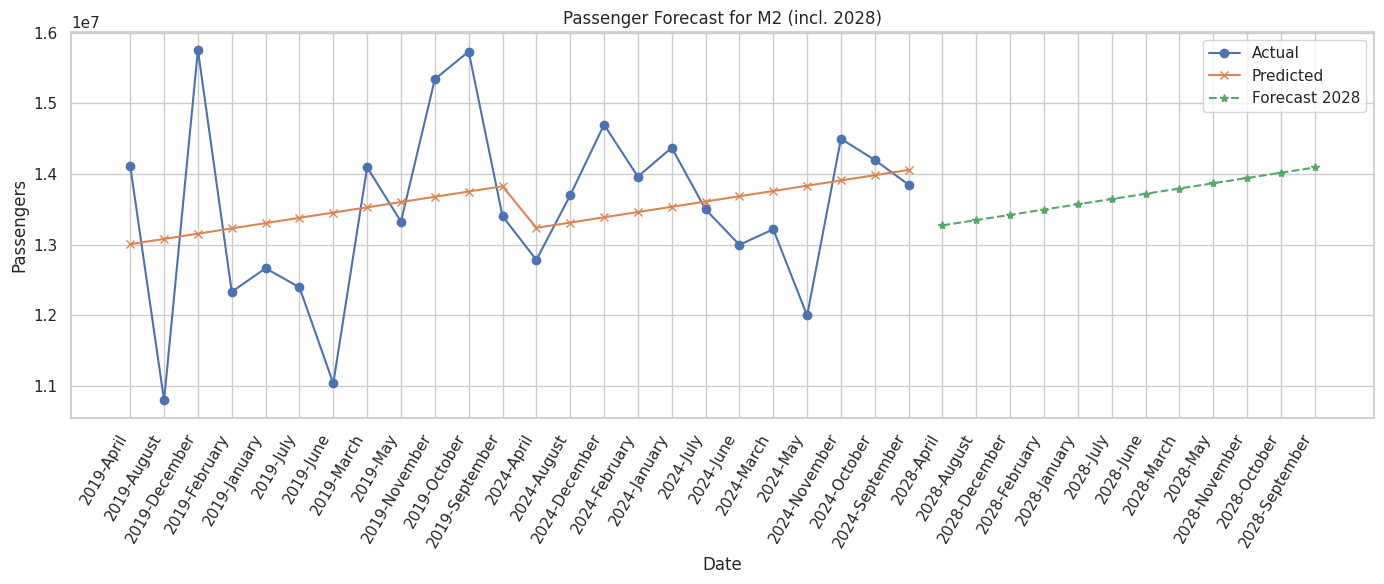

,Year,Month,Predicted Passengers,Date
0,2028,April,13274999,2028-April
1,2028,August,13349482,2028-August
2,2028,December,13423965,2028-December
3,2028,February,13498447,2028-February
4,2028,January,13572930,2028-January
5,2028,July,13647413,2028-July
6,2028,June,13721895,2028-June
7,2028,March,13796378,2028-March
8,2028,May,13870861,2028-May
9,2028,November,13945343,2028-November


In [19]:
predict_passengers_with_forecast("M2", forecast_year=2026)

## ML Method 2: Clustering Metro Lines by Ridership Per Capita
*Applied* **K-Means clustering** to group Istanbul metro, tram, funicular, and teleferik lines based on their **average monthly passengers per capita** (i.e., ridership normalized by Istanbul’s population).


In [22]:
# Group data: average passengers per capita by metro line
df_cluster = df.groupby("Metro Line")["Passengers Per Capita"].mean().reset_index()
df_cluster.columns = ["Metro Line", "Avg Passengers Per Capita"]

In [23]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(df_cluster[["Avg Passengers Per Capita"]])


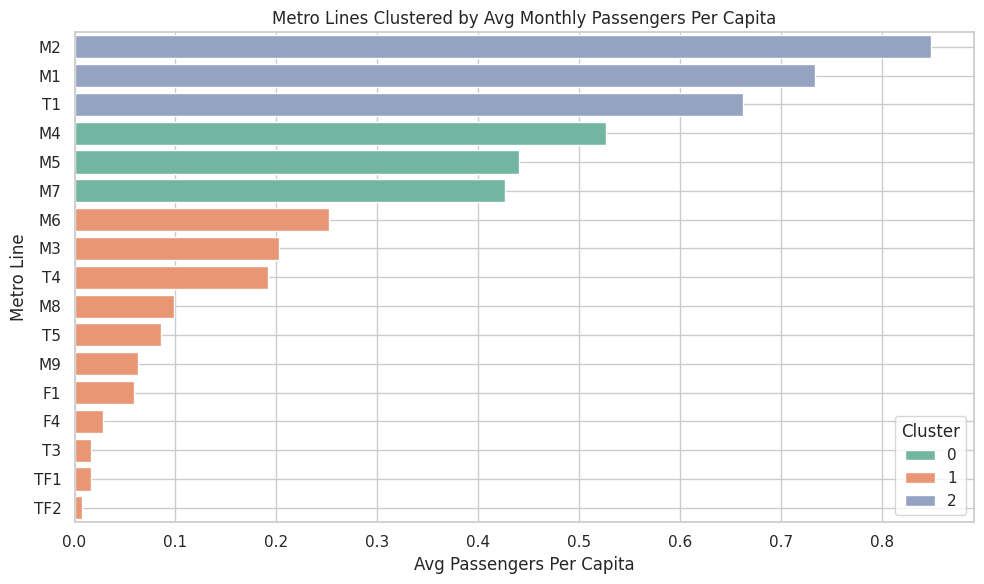

In [24]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cluster.sort_values("Avg Passengers Per Capita", ascending=False),
            x="Avg Passengers Per Capita", y="Metro Line", hue="Cluster", dodge=False, palette="Set2")
plt.title("Metro Lines Clustered by Avg Monthly Passengers Per Capita")
plt.xlabel("Avg Passengers Per Capita")
plt.ylabel("Metro Line")
plt.legend(title="Cluster")
plt.tight_layout()
plt.grid(True)
plt.show()


In [25]:
# Return the clustered dataframe for reference
df_cluster.sort_values("Cluster")

,Metro Line,Avg Passengers Per Capita,Cluster
6,M5,0.440233,0
5,M4,0.526575,0
8,M7,0.426271,0
0,F1,0.059283,1
4,M3,0.202270,1
7,M6,0.252632,1
9,M8,0.098609,1
1,F4,0.028664,1
14,T5,0.085380,1
13,T4,0.191981,1
